In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib

### Загрузка данных

In [3]:
mri_data = pd.read_csv("mri_dataset.csv", index_col=0)
mri_data.drop("target", axis=1, inplace=True)

labels = pd.read_csv("classes.csv", index_col=0)
labels["pos E/neg E"] = labels["pos E+DE/neg E"].apply(lambda x: "posE" if x == "posE/DE" else x)
labels.drop("pos E+DE/neg E", axis=1, inplace=True)

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "posE", "negE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
EC_idx = labels["E/C"].notnull()
TLE_idx = labels["TLE/no E"].notnull()
TLEC_idx = labels["TLE/C"].notnull()
DC_idx = labels["D/C"].notnull()
DEE_idx = labels["DE/E"].notnull()
PENE_idx = labels["pos E/neg E"].notnull()

In [4]:
mri_data.head()

,bankssts_NumVert,caudalanteriorcingulate_NumVert,caudalmiddlefrontal_NumVert,cuneus_NumVert,entorhinal_NumVert,fusiform_NumVert,inferiorparietal_NumVert,inferiortemporal_NumVert,isthmuscingulate_NumVert,lateraloccipital_NumVert,...,Right-WM-hypointensities_normRange,non-WM-hypointensities_normRange,Left-non-WM-hypointensities_normRange,Right-non-WM-hypointensities_normRange,Optic-Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange,CC_Anterior_normRange
patient_number,,,,,,,,,,,,,,,,,,,,,
P001,1794,1030,3395,2525,660,6353,7740,5702,1631,9444,...,0.0,0.0,0.0,0.0,86.0,79.0,105.0,77.0,73.0,84.0
P002,1893,1117,4504,2560,845,5522,10129,7056,1707,9203,...,0.0,0.0,0.0,0.0,94.0,78.0,108.0,97.0,90.0,92.0
P003,1089,900,2295,2624,666,4210,6247,5159,1575,7472,...,0.0,0.0,0.0,0.0,83.0,94.0,95.0,97.0,81.0,129.0
P004,1624,1755,3126,2859,614,4284,6865,4909,1688,9196,...,0.0,0.0,0.0,0.0,90.0,79.0,96.0,94.0,119.0,117.0
P006,1377,1186,4497,3258,503,5292,7041,6269,1647,9720,...,0.0,0.0,0.0,0.0,110.0,71.0,76.0,85.0,77.0,111.0


In [5]:
labels.head()

,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,pos E/neg E
patient_number,,,,,,,,,
P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0
P002,3,2,1,NaN,NaN,NaN,NaN,3.0,NaN
P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0
P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN
P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0


In [6]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [7]:
def get_svc_grid(cv, dim_reduction_methods, random_state=None,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [8]:
def get_lr_grid(cv, dim_reduction_methods, random_state=None,
                 lr_c_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [9]:
def get_rfc_grid(cv, dim_reduction_methods, random_state=None,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [10]:
def get_knn_grid(cv, dim_reduction_methods, random_state=None,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [11]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [12]:
def print_results(clf_grid_dict):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))
    print()
    print("mean =", results["mean"].max())
    print("std =", results.loc[results["mean"].argmax(), "std"])

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN)

In [13]:
def train_grid_cv(X, y, n_splits, n_repeats, random_state=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    n_features = [5, 10, 20, 50, 100]
    n_components = [2, 3, 5, 10, 15, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [PCA(n) for n in n_components]
    dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, random_state=random_state,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(-6, 4, 2)],
                               svc_gamma_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_svc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, random_state=random_state,
                             lr_c_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_lr.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, random_state=random_state,
                               rfc_n_estimators_l=[i for i in range(300, 950, 150)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = y.size // len(set(y)) - 5
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, random_state=random_state,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 2)])
    start_time = time.time()
    grid_cv_knn.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn
                  })
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [14]:
def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(X.shape[0])]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr, :], y[idx_tr])
        pred_te = estimator.predict(X.iloc[idx_te])
        for i, idx in enumerate(idx_te):
            predictions[idx].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [15]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

### Training

In [16]:
labels.head()

,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,pos E/neg E
patient_number,,,,,,,,,
P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0
P002,3,2,1,NaN,NaN,NaN,NaN,3.0,NaN
P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0
P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN
P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0


dataset: MRI T1
* 4 classes
* Epilepsy / no epilepsy
* Depression / no depression
* Epilepsy / control
* Depression / control
* Epilepsy with depression / only epilepsy
* TLE / no epilepsy
* TLE / control
* MRI positive / MRI negative epilepsy

### 4 classes

Training SVC...
(training took 5402.644208192825s)

Training LR...
(training took 403.1392719745636s)

Training RFC...
(training took 4961.843548536301s)

Training KNN...
(training took 2757.3463599681854s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__n_neighbors = 17, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.368,0.074673
LR,classifier__C = 1,"LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,\n method='standard', modified_tol=1e-12, n_components=20,...",0.364,0.099519
RFC,classifier__n_estimators = 750,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7f9d94e077b8>)",0.410,0.081240
SVC,"classifier__kernel = rbf, classifier__C = 100, classifier__gamma = 0.0001","PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.412,0.090863


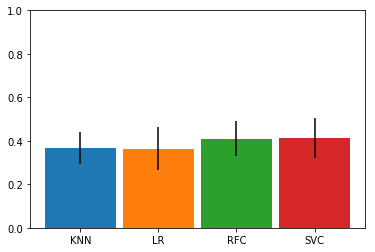

0it [00:00, ?it/s]

Best model: 
SVC
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
classifier__kernel = rbf
classifier__C = 100
classifier__gamma = 0.0001

mean = 0.412
std = 0.0908625335328


50it [00:01, 26.95it/s]


In [51]:
n_splits = 5
X, y = mri_data, labels.target

best_model_mri_DE, grid_cv_svc_mri_DE, grid_cv_lr_mri_DE, grid_cv_rfc_mri_DE, grid_cv_knn_mri_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DE = repeated_cross_val_predict(best_model_mri_DE, X, y, cv, file="labels_mri_DE.csv")

save_model(best_model_mri_DE, "best_model_mri_DE.pkl")

Training SVC...
(training took 962.3522219657898s)

Training LR...
(training took 11.85269570350647s)

Training RFC...
(training took 609.9492726325989s)

Training KNN...
(training took 126.03718209266663s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__n_neighbors = 7, classifier__weights = distance","PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.35,0.100000
LR,classifier__C = 0.01,"SelectKBest(k=50, score_func=<function ttest_ind at 0x7f9d94e077b8>)",0.31,0.091652
RFC,classifier__n_estimators = 300,"PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.38,0.071414
SVC,"classifier__kernel = rbf, classifier__C = 100, classifier__gamma = 0.01","SelectKBest(k=100, score_func=<function ttest_ind at 0x7f9d94e077b8>)",0.42,0.090000


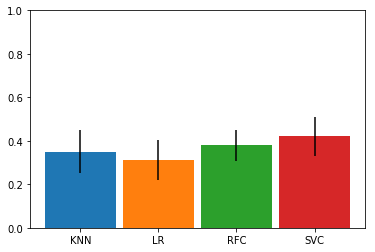

5it [00:00, 43.29it/s]

Best model: 
SVC
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x7f9d94e077b8>)
classifier__kernel = rbf
classifier__C = 100
classifier__gamma = 0.01

mean = 0.42
std = 0.09


50it [00:00, 56.54it/s]


In [47]:
n_splits = 5
X, y = mri_data, labels.target

best_model_mri_DE, grid_cv_svc_mri_DE, grid_cv_lr_mri_DE, grid_cv_rfc_mri_DE, grid_cv_knn_mri_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DE = repeated_cross_val_predict(best_model_mri_DE, X, y, cv, file="labels_mri_DE.csv")

save_model(best_model_mri_DE, "best_model_mri_DE.pkl")

### Epilepsy / no epilepsy

In [52]:
n_splits = 10
X, y = mri_data, labels["E/no E"]

best_model_mri_E, grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_E = repeated_cross_val_predict(best_model_mri_E, X, y, cv, file="labels_mri_E.csv")

save_model(best_model_mri_E, "best_model_mri_E.pkl")

Training SVC...
(training took 10575.506497383118s)

Training LR...
(training took 762.2717778682709s)

Training RFC...


KeyboardInterrupt: 

### Depression / no depression

In [26]:
n_splits = 10
X, y = mri_data, labels["D/no D"]

best_model_mri_D, grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_D = repeated_cross_val_predict(best_model_mri_D, X, y, cv, file="labels_mri_D.csv")

save_model(best_model_mri_D, "best_model_mri_D.pkl")

### Epilepsy / control

Training SVC...
(training took 303.95731234550476s)

Training LR...
(training took 10.24242377281189s)

Training RFC...
(training took 917.6724207401276s)

Training KNN...
(training took 134.008887052536s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
LR,classifier__C = 1e-06,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.67,0.167631
RFC,classifier__n_estimators = 300,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.71,0.137477
KNN,"classifier__weights = distance, classifier__n_neighbors = 5, classifier__p = 1","SelectKBest(k=5, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.68,0.107703
SVC,"classifier__kernel = rbf, classifier__gamma = 1, classifier__C = 1e-06","SelectKBest(k=5, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.68,0.188680


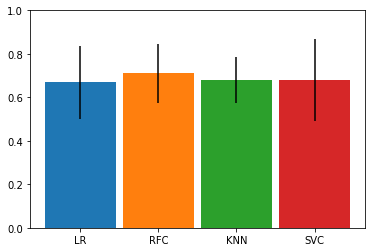

0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 300
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f6955ad1510>)

mean = 0.71
std = 0.137477270849


50it [00:34,  1.45it/s]


In [32]:
n_splits = 5
X, y = mri_data[EC_idx], labels[EC_idx]["E/C"]

best_model_mri_EC, grid_cv_svc_mri_EC, grid_cv_lr_mri_EC, grid_cv_rfc_mri_EC, grid_cv_knn_mri_EC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_EC = repeated_cross_val_predict(best_model_mri_EC, X, y, cv, file="labels_mri_EC.csv")

save_model(best_model_mri_EC, "best_model_mri_EC.pkl")

### Depression / control

In [ ]:
n_splits = 5
X, y = mri_data[DC_idx], labels[DC_idx]["D/C"]

best_model_mri_DC, grid_cv_svc_mri_DC, grid_cv_lr_mri_DC, grid_cv_rfc_mri_DC, grid_cv_knn_mri_DC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DC = repeated_cross_val_predict(best_model_mri_DC, X, y, cv, file="labels_mri_DC.csv")

save_model(best_model_mri_DC, "best_model_mri_DC.pkl")

### Epilepsy with depression / only epilepsy

Training SVC...
(training took 244.844055891037s)

Training LR...
(training took 10.326315879821777s)

Training RFC...
(training took 821.5884339809418s)

Training KNN...
(training took 121.74868297576904s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__weights = distance, classifier__n_neighbors = 11","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.58,0.132665
LR,classifier__C = 1e-06,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.63,0.141774
SVC,"classifier__gamma = 1, classifier__C = 1e-06, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.62,0.087178
RFC,classifier__n_estimators = 450,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.59,0.164012


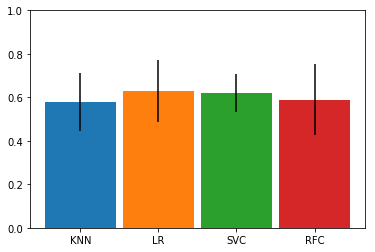

8it [00:00, 75.35it/s]

Best model: 
LR
classifier__C = 1e-06
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)

mean = 0.63
std = 0.141774468788


50it [00:00, 97.03it/s]


In [17]:
n_splits = 5
X, y = mri_data[DEE_idx], labels[DEE_idx]["DE/E"]

best_model_mri_DEE, grid_cv_svc_mri_DEE, grid_cv_lr_mri_DEE, grid_cv_rfc_mri_DEE, grid_cv_knn_mri_DEE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DEE = repeated_cross_val_predict(best_model_mri_DEE, X, y, cv, file="labels_mri_DEE.csv")

save_model(best_model_mri_DEE, "best_model_mri_DEE.pkl")

### TLE / no epilepsy

Training SVC...
(training took 244.844055891037s)

Training LR...
(training took 10.326315879821777s)

Training RFC...
(training took 821.5884339809418s)

Training KNN...
(training took 121.74868297576904s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__weights = distance, classifier__n_neighbors = 11","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.58,0.132665
LR,classifier__C = 1e-06,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.63,0.141774
SVC,"classifier__gamma = 1, classifier__C = 1e-06, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.62,0.087178
RFC,classifier__n_estimators = 450,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.59,0.164012


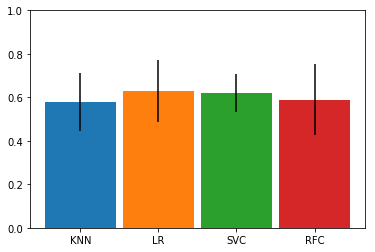

8it [00:00, 75.35it/s]

Best model: 
LR
classifier__C = 1e-06
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)

mean = 0.63
std = 0.141774468788


50it [00:00, 97.03it/s]


In [17]:
n_splits = 5 # ?
X, y = mri_data[TLE_idx], labels[TLE_idx]["TLE/no E"]

best_model_mri_TLE, grid_cv_svc_mri_TLE, grid_cv_lr_mri_TLE, grid_cv_rfc_mri_TLE, grid_cv_knn_mri_TLE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLE = repeated_cross_val_predict(best_model_mri_TLE, X, y, cv, file="labels_mri_TLE.csv")

save_model(best_model_mri_TLE, "best_model_mri_TLE.pkl")

In [24]:
labels[TLE_idx]["TLE/no E"].value_counts()

4.0    50
6.0    31
Name: TLE/no E, dtype: int64

### TLE / control

In [ ]:
n_splits = 5 # ?
X, y = mri_data[TLEC_idx], labels[TLEC_idx]["TLE/C"]

best_model_mri_TLEC, grid_cv_svc_mri_TLEC, grid_cv_lr_mri_TLEC, grid_cv_rfc_mri_TLEC, grid_cv_knn_mri_TLEC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLEC = repeated_cross_val_predict(best_model_mri_TLEC, X, y, cv, file="labels_mri_TLEC.csv")

save_model(best_model_mri_TLEC, "best_model_mri_TLEC.pkl")

Training SVC...


In [23]:
labels[TLEC_idx]["TLE/C"].value_counts()

6.0    31
0.0    25
Name: TLE/C, dtype: int64

### MRI positive / MRI negative epilepsy

Training SVC...
(training took 244.844055891037s)

Training LR...
(training took 10.326315879821777s)

Training RFC...
(training took 821.5884339809418s)

Training KNN...
(training took 121.74868297576904s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__weights = distance, classifier__n_neighbors = 11","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.58,0.132665
LR,classifier__C = 1e-06,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.63,0.141774
SVC,"classifier__gamma = 1, classifier__C = 1e-06, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.62,0.087178
RFC,classifier__n_estimators = 450,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.59,0.164012


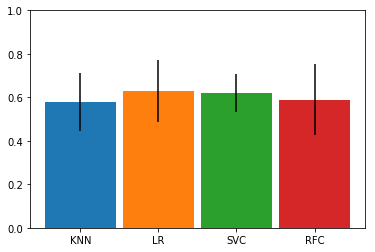

8it [00:00, 75.35it/s]

Best model: 
LR
classifier__C = 1e-06
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)

mean = 0.63
std = 0.141774468788


50it [00:00, 97.03it/s]


In [17]:
n_splits = 3 # ?
X, y = mri_data[PENE_idx], labels[PENE_idx]["pos E/neg E"]

best_model_mri_PENE, grid_cv_svc_mri_PENE, grid_cv_lr_mri_PENE, grid_cv_rfc_mri_PENE, grid_cv_knn_mri_PENE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_PENE = repeated_cross_val_predict(best_model_mri_PENE, X, y, cv, file="labels_mri_PENE.csv")

save_model(best_model_mri_PENE, "best_model_mri_PENE.pkl")

In [21]:
labels[PENE_idx]["pos E/neg E"].value_counts()

8.0    19
7.0     7
Name: pos E/neg E, dtype: int64